<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkitB_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

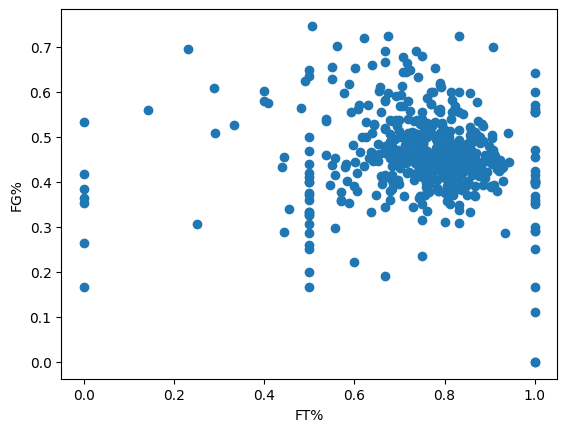

In [ ]:
#For this, I can use the code from the notes
plt.scatter(basketball['FT%'] , basketball['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

The most striking pattern is the cluster of values at the horizontal coordinates: 0, 0.5, and 1. These initially come off as unintuitive, as NBA scoring %'s are supposed to be more 'random', but it matches due to the decision to include players that haven't played for long periods of time. Because their 'game time' is extremely small, many of such players haven't had the time to shoot many free throws. As such, the vast array of (typically benchwarmers) NBA players that see very little game time is represented by geometric values correlated to 0/1, 1/2, 1/1, etc.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

Text(0, 0.5, 'FG%')

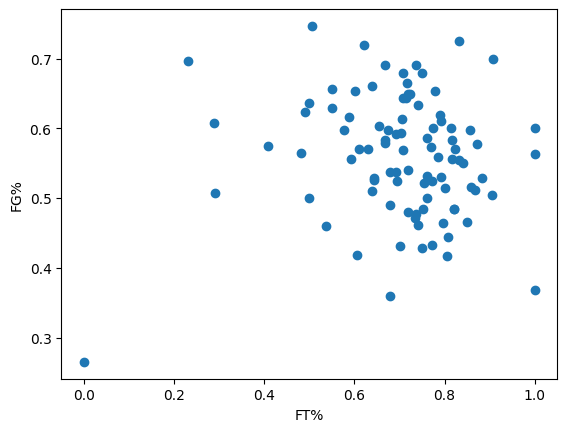

In [ ]:
#I'm just going to do this position by position because that seems like the simplest way to code it.
#First, I'll organize data by position, then make a scatterplot
#Center
c_data = basketball.query("Pos == 'C'")
plt.scatter(c_data['FT%'] , c_data['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

Text(0, 0.5, 'FG%')

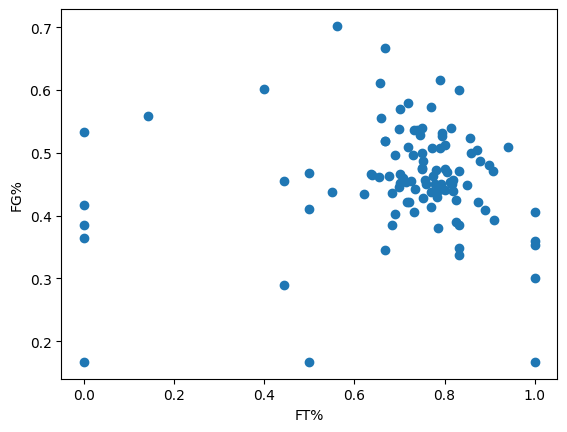

In [ ]:
#Power Forward
pf_data = basketball.query("Pos == 'PF'")
plt.scatter(pf_data['FT%'] , pf_data['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

Text(0, 0.5, 'FG%')

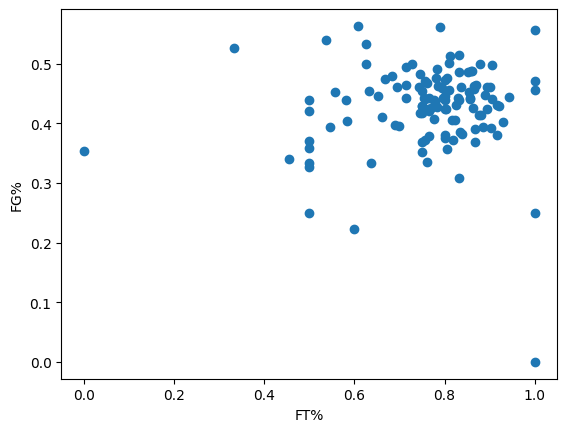

In [ ]:
#Shooting Guard
sg_data = basketball.query("Pos == 'SG'")
plt.scatter(sg_data['FT%'] , sg_data['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

Text(0, 0.5, 'FG%')

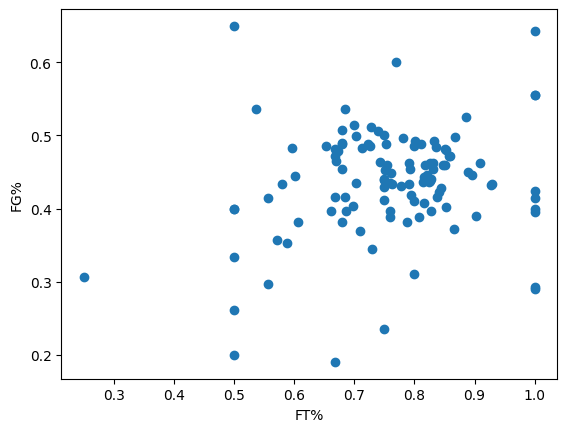

In [ ]:
#Small Forward
sf_data = basketball.query("Pos == 'SF'")
plt.scatter(sf_data['FT%'] , sf_data['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

Text(0, 0.5, 'FG%')

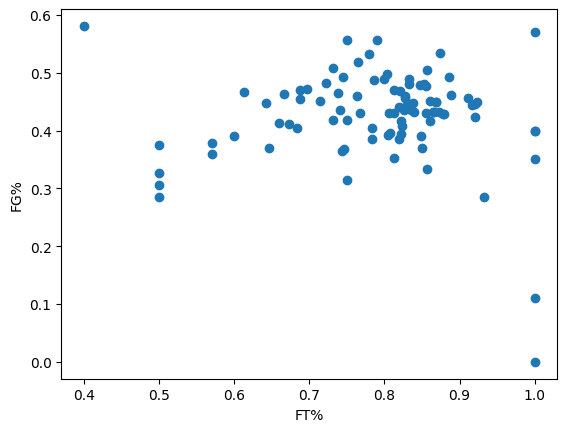

In [ ]:
#Point Guard
pg_data = basketball.query("Pos == 'PG'")
plt.scatter(pg_data['FT%'] , pg_data['FG%'],)
plt.xlabel("FT%")
plt.ylabel("FG%")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The reason why a linear regression model fails for the full dataset is because it's impossible for the model to give weight to the values near (0, 0), even if they're not exactly at the origin. Specifically, the points in the very bottom left of the center and power forward graphs represent 'high leverage values'. The model is left with two conflicting slopes: one running up and to the right towards the cluster and one running down and to the right from above the cluster. Because there is so much variance (as the 'high leverage point' drastically distorts the data), it's near-impossible for the model to run. Even if the model could run, the results would likely contain many divergences and may not make logical sense.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [ ]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

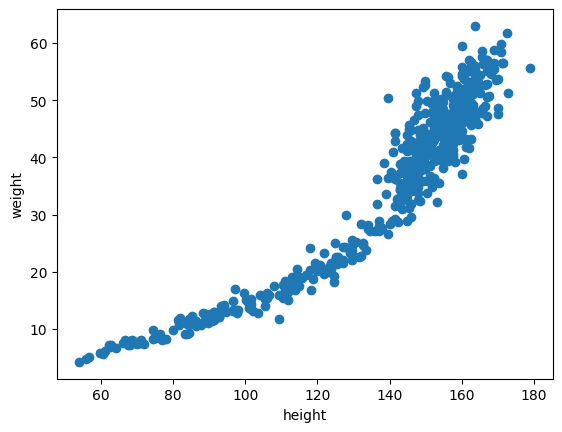

In [ ]:
#For this, I can similar code from above
plt.scatter(howell['height'] , howell['weight'],)
plt.xlabel("height")
plt.ylabel("weight")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
#lKKS stands for linear Kalahari !Kung San people
#since this is a linear model and we're not generalizing it yet, I can generally
#use the same code as the notes
with pm.Model() as model_lKKS:
    #priors
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    #the 'linear' portion of the model
    μ = pm.Deterministic("μ", α + β * howell.height)
    #prior for the standard deviation of the likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)
    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = howell.weight)
    #inference data object
    idata_lKKS = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

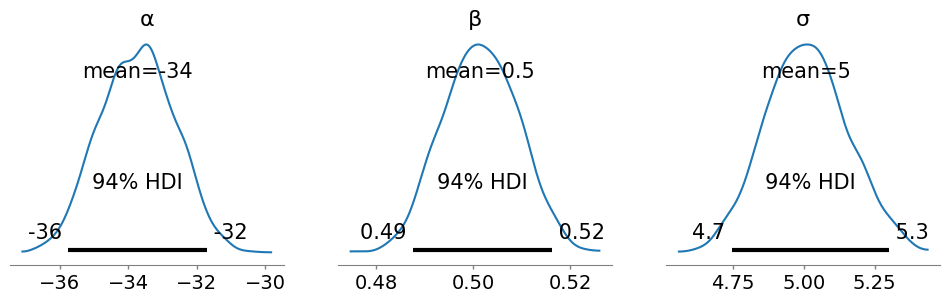

In [ ]:
#same as from the notes
az.plot_posterior(idata_lKKS, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'weight')

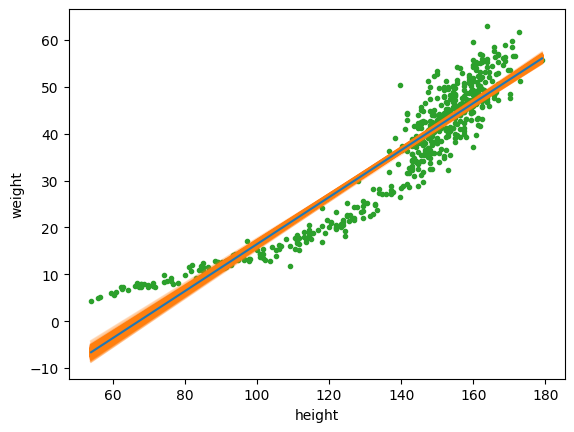

In [20]:
#I'm going to use the same code as the notes, but I will increase the sample
#size to improve accuracy
posterior = az.extract(idata_lKKS, num_samples = 1000)
#grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )
# this creates the expected line, the path we predict weight and
#height deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
#set up plot
_, ax = plt.subplots()
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")
#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
#labeling axes
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
#posterior predictive data, as usual
pm.sample_posterior_predictive(idata_lKKS, model=model_lKKS,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

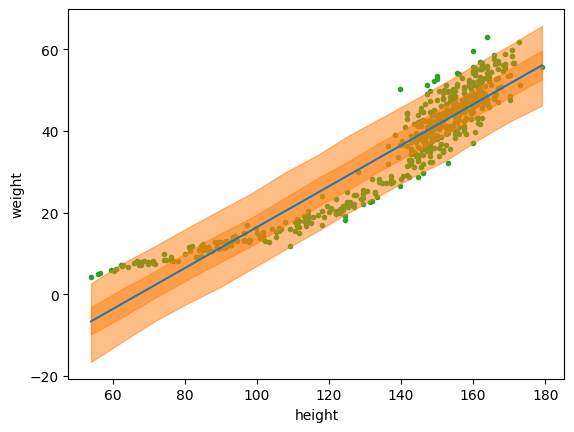

In [23]:
#this would be complex, but the code from the notes still applies here, so I
#just need to insert the new values in
mean_line = idata_lKKS.posterior["μ"].mean(("chain", "draw"))
#creates some x values to run through our line formula
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)
#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lKKS.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")
#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_pred'>

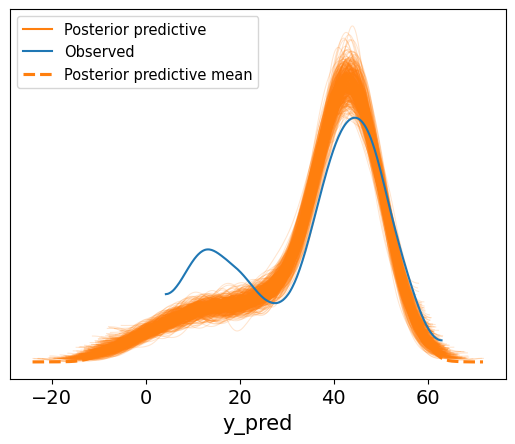

In [24]:
#ppc, as usual. Using more samples than the notes
az.plot_ppc(idata_lKKS, num_pp_samples=500, colors=["C1", "C0", "C1"])

The model doesn't fit because it doesn't adjust for the spike/bump in values and thereby doesn't account for the curvature of the original data. Specifically, it completely fails to account for the bump around the domain (5, 25).

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [34]:
#gKKS for generalized KKS, can use some of the same code as the linear model,
#but have to change the mean line and some other things to fit the data
with pm.Model() as model_gKKS:
    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    #mean line, using an exponent because the data seems like it would be exponential
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))
    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)
    #normal likelihood
    y_pred = pm.Normal("y_pred", mu = μ, sigma = σ, observed = howell.weight)
    idata_gKKS = pm.sample()

Output()

Output()

In [35]:
#posterior predictive for the graph
pm.sample_posterior_predictive(idata_gKKS, model=model_gKKS,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

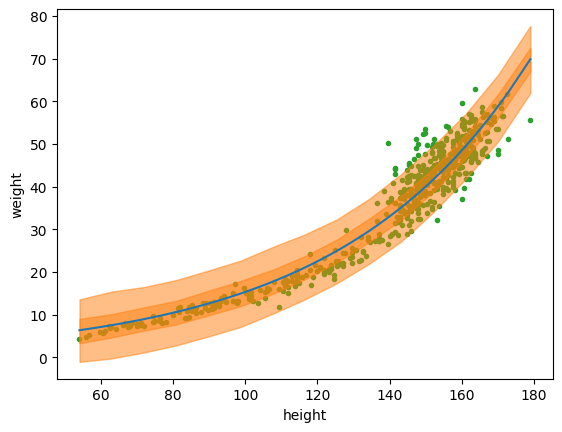

In [36]:
#I can use the same graphing mechanism as in the notes, the first one seemed a
#little off so I'm using the bikes example
mean_line = idata_gKKS.posterior["μ"].mean(("chain", "draw"))
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)
y_pred_q = idata_gKKS.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

<Axes: xlabel='y_pred'>

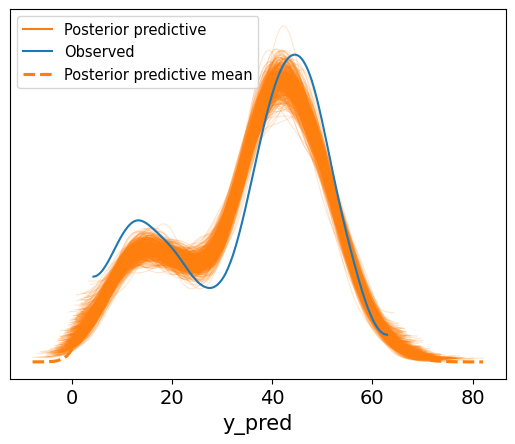

In [37]:
#ppc, as usual. Using more samples than the notes
az.plot_ppc(idata_gKKS, num_pp_samples=500, colors=["C1", "C0", "C1"])

The posterior predictive distribution was above, which I used to model the generalized model.

The model seems to fit the observed data very well. It correlated extremely well with both bumps, but it's values are slightly off. Because it matches the general trends of the observed data, the model is sufficiently accurate. To improve the accuracy, it'd likely require to be more precise with the priors to match the conditions of the Kalahari !Kung San.